# CNN - Project Part 4
#### • DOMAIN: 
> Botanical research
####• CONTEXT: 
> University X is currently undergoing some research involving understanding the characteristics of flowers. They already have have invested on curating sample images. They require an automation which can
create a classifier capable of determining a flower’s species from a photo
#### • DATA DESCRIPTION: 
> The dataset comprises of images from 17 plant species. It can be downloaded from TensorFlow.
#### • PROJECT OBJECTIVE: 
> Company’s management requires an automation which can create a classifier capable of determining a flower’s species from a photo.

# (1) Import Python libraries
## 1.1 Enable GPU for this notebook


In [155]:
import tensorflow as tf
print("You are using TensorFlow version", tf.__version__)
if len(tf.config.list_physical_devices('GPU')) > 0:
  print("You have a GPU enabled.")
else:
  print("Enable a GPU before running this notebook.")

from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense, Dropout, InputLayer, BatchNormalization 
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPool2D, GlobalMaxPool2D 
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
%matplotlib inline
from tqdm.notebook import trange, tqdm
import seaborn as sns
from google.colab.patches import cv2_imshow
from IPython.display import Image, display, Markdown, clear_output

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn import svm, metrics
from xgboost import XGBClassifier


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

You are using TensorFlow version 2.4.1
You have a GPU enabled.


## (1.2) Install `tflearn` that contains the `Oxford Flower-17 Image sets`

In [59]:
!pip install tflearn

In [60]:
import tflearn
import tflearn.datasets.oxflower17 as oxflower17

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# (2) Visualise the Image dataset

## (2.1) Load the dataset

In [62]:

X, y = oxflower17.load_data(resize_pics=(224, 224))


In [63]:
X[0].min(), X[0].max()
X.shape, y.shape

((1360, 224, 224, 3), (1360,))

#### Observations:
1. The image dataset already seems to be standardised between `0.0` and `1.0`. Hence, additional rescaling is not required.

In [64]:
display(Markdown(f"#### Shape of the image set is {X.shape}"))

#### Shape of the image set is (1360, 224, 224, 3)

#### Observations:
1. There are about `1360` images of `224 X 224` pixels with `3` channels i.e `RGB`.

## (2.2) Visualise one sample from each flower species

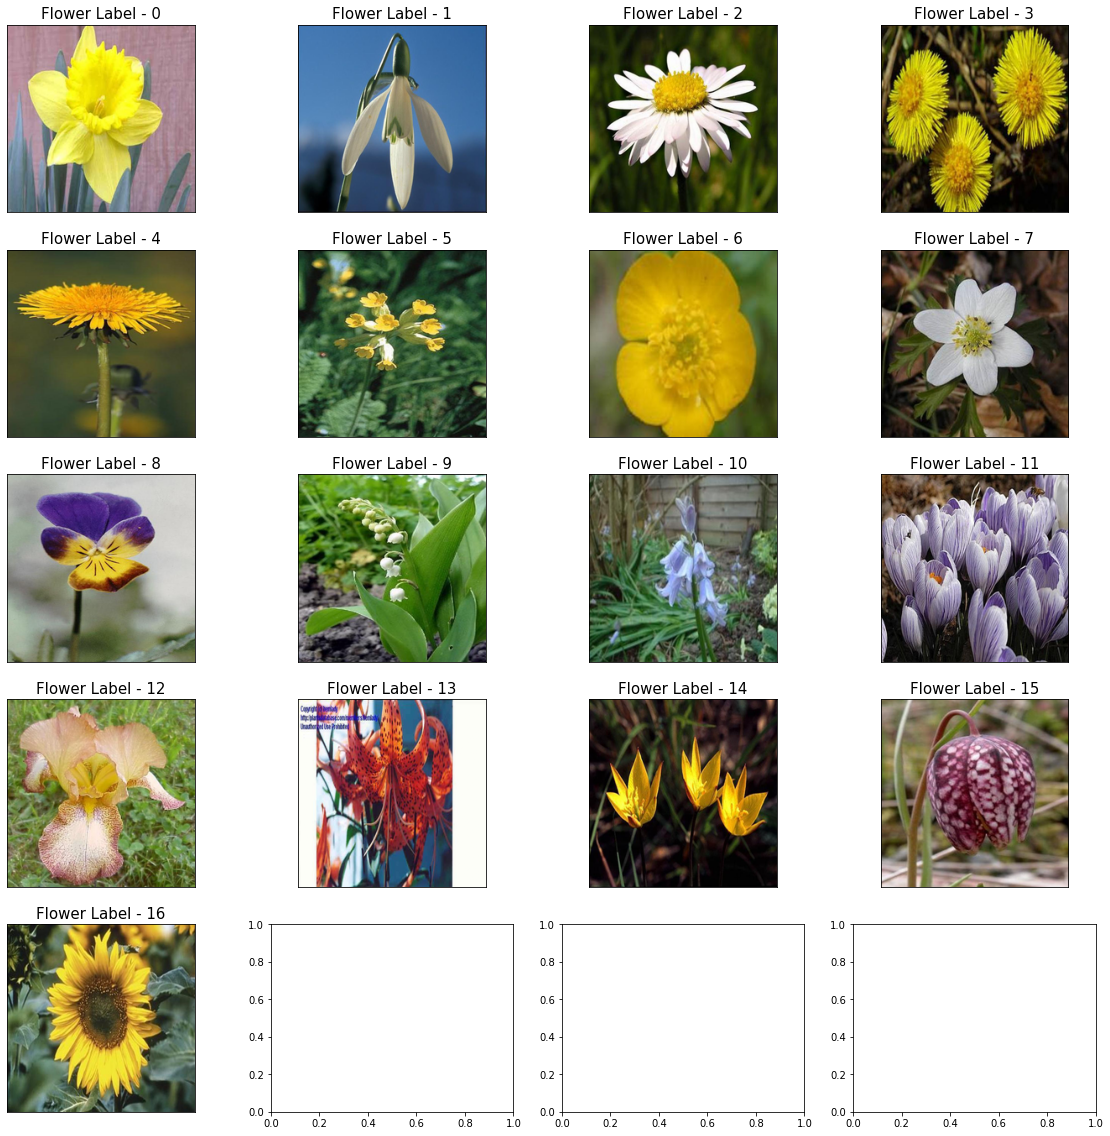

In [68]:
cols = 4
rows = int(np.ceil(len(np.unique(y))/cols))
rows, cols
# print(rows,cols)


fig, ax = plt.subplots(rows,cols,figsize=(20,20))
for i in np.unique(y):
  if i < cols:
    col = i
    row = int(i/4)
  else:
    col = i % 4
    row = int(i/4)
  
  loc = list(y).index(i)
  ax[row][col].imshow(X[loc])
  ax[row][col].tick_params(top=False, bottom=False, left=False, right=False,labelleft=False, labelbottom=False)
  ax[row][col].set_title(f"Flower Label - {i}",{'fontsize':15})
plt.show()


#### Observations:
1. There are 17 species of flowers in the dataset.

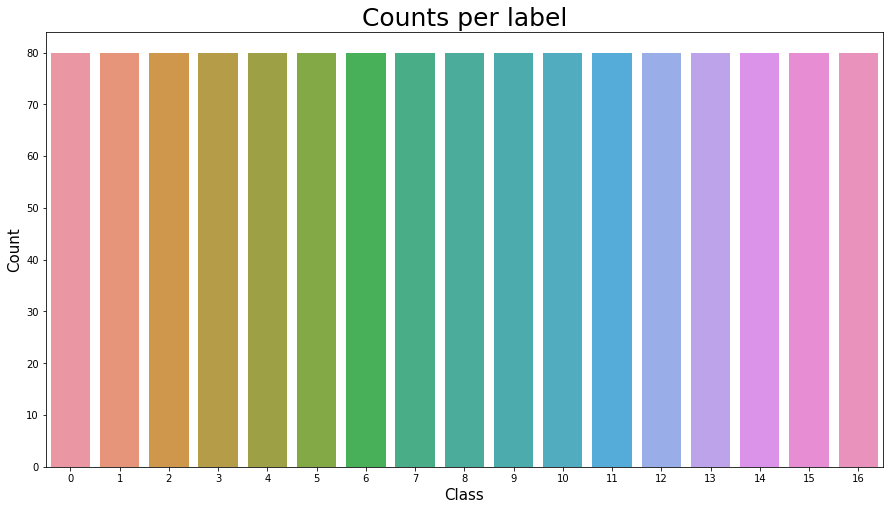

In [66]:
plt.subplots(figsize=(15,8))
sns.countplot(x=y)
plt.title("Counts per label",{'fontsize':25})
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Class",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.show()

#### Observations:
1. Its a perfectly balanced dataset with `80` images for each species.

# (3) Modelling
## (3.1) Initialise global variables to be used in modelling

In [69]:
project_path = '/content/drive/MyDrive/Colab Notebooks'
img_rsz_ht , img_rsz_wd  = 224, 224
random_state = 200
num_channels = 3
batch_size = 32
epochs = 1000
model_type = "cnn"

score_board = pd.DataFrame(columns=['Model','Loss','Accuracy','Predicted Label','Notes'])

## (3.2)  Train and Test Split the image set

In [70]:
X_train,X_val,y_train,y_val = train_test_split(X,y,shuffle=True, test_size=0.4,random_state=random_state)
X_val,X_test,y_val,y_test  = train_test_split(X_val,y_val,shuffle=True,test_size=0.5,random_state=random_state)

display(Markdown(f"#### Shapes of Train, Validation and Test data sets are :{X_train.shape}, {X_val.shape}, {X_test.shape}"))

#### Shapes of Train, Validation and Test data sets are :(816, 224, 224, 3), (272, 224, 224, 3), (272, 224, 224, 3)

In [71]:
op_classes = len(np.unique(y_train))
op_classes

17

In [72]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=op_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=op_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=op_classes)


In [73]:
# data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=None,
#                                                             rotation_range=20, 
#                                                             width_shift_range=0.2,
#                                                             height_shift_range=0.2,
#                                                             horizontal_flip=True,
#                                                             vertical_flip=True,
#                                                             fill_mode = 'nearest',
#                                                             validation_split=0.2
#                                                             ) 

In [74]:
# train_gen = data_gen.flow_from_directory('/content/17flowers/jpg',
#                                           target_size=(img_rsz_ht, img_rsz_wd),
#                                           subset='training',
#                                           class_mode='sparse',
#                                           batch_size=batch_size,
#                                           shuffle=True,
#                                           seed=random_state
#                                           )

In [75]:
# val_gen = data_gen.flow_from_directory('/content/17flowers/jpg',
#                                         target_size=(img_rsz_ht, img_rsz_wd),                                                   
#                                         subset='validation',
#                                         class_mode='sparse',
#                                         batch_size=batch_size,
#                                         shuffle=True,
#                                         seed=random_state
#                                         )

## (3.3) Reading the image to be detected.

### <u>Original Image to be predicted (224, 224, 3)

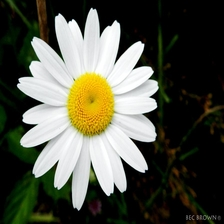

(1, 224, 224, 3)

In [76]:
img_pred = cv2.imread('/content/drive/MyDrive/Colab Notebooks/DataFile/Flowers - Classification/Flower Prediction - Expected.jpg')
display(Markdown(f"### <u>Original Image to be predicted {img_pred.shape}"))
cv2_imshow(img_pred)
img_predict = np.expand_dims(img_pred, axis=0)
img_predict.shape

#### Observations:
1. The image above seems to be a `daisy` with class lable `2`.

## (3.4) Create helper classes for creating CNN,ANN and LivePlots

### (3.4.1) Helper Class for LivePlots

In [81]:

class LivePlot(tf.keras.callbacks.Callback):
    def __init__(self,refresh_rate=5,train_loss=None,train_metric=None):
        self.validation_prefix = "val_"
        self.refresh_rate = refresh_rate
        self.train_loss = train_loss
        self.val_loss = self.validation_prefix + train_loss
        self.train_metric = train_metric
        self.val_metric = self.validation_prefix + train_metric
        
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and metrics
        self.train_losses = []
        self.train_metrics = []
        self.val_losses = []
        self.val_metrics = []
        
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        """
        Calculates and plots loss and metrics
        """
        # Extract from the log
        log_train_loss = logs.get(self.train_loss)
        log_train_metric = logs.get(self.train_metric)
        log_val_loss = logs.get(self.val_loss)
        log_val_metric = logs.get(self.val_metric)
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.train_losses.append(log_train_loss)
        self.train_metrics.append(log_train_metric)
        self.val_losses.append(log_val_loss)
        self.val_metrics.append(log_val_metric)
        
        # Plots every nth epoch
        if epoch > 0 and epoch%self.refresh_rate == 0:
            fig, ax = plt.subplots(1,2,figsize=(20,6)) 
            clear_output(wait=True)
            N = np.arange(0, len(self.train_losses))
            
            sns.lineplot(x=N,y=self.train_losses,ax=ax[0],legend='brief',label=self.train_loss)
            sns.lineplot(x=N, y = self.val_losses,ax=ax[0],legend='brief',label=self.val_loss)
            ax[0].set_title('Loss over Epoch',{'fontsize':20})
            # ax[0].set_title(f'Loss over Epoch {epoch} - {log_train_loss:.3}/{log_val_loss:.3} - (T/V)\n',{'fontsize':20})
            ax[0].set_xlabel('Epochs')
            ax[0].set_ylabel(self.train_loss)
            
            sns.lineplot(x=N,y=self.train_metrics,ax=ax[1],legend='brief',label=self.train_metric)
            sns.lineplot(x=N,y=self.val_metrics,ax=ax[1],legend='brief',label=self.val_metric)
            ax[1].set_title('Performance over Epoch ',{'fontsize':20})
            # ax[1].set_title(f'Performance over Epoch {epoch} - {log_train_metric:.3}/{log_val_metric:.3} - (T/V) \n',{'fontsize':20})
            ax[1].set_xlabel('Epochs')
            ax[1].set_ylabel(self.train_metric)
            plt.show()
            

### (3.4.2) Helper Class for creating a CNN

In [82]:

def createCNNModel(img_shape,num_ops,loss='categorical_crossentropy',metrics=['accuracy'] ):

  model = tf.keras.models.Sequential()
  model.add(InputLayer(input_shape=(img_shape[0],img_shape[1],img_shape[2])))

  model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
  model.add(MaxPool2D(pool_size = (2,2)))
  model.add(BatchNormalization())

  model.add(Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu'))
  model.add(MaxPool2D(pool_size = (2,2)))
  model.add(BatchNormalization())

  model.add(Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))
  model.add(MaxPool2D(pool_size = (2,2)))
  model.add(BatchNormalization())

  model.add(Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))
  model.add(MaxPool2D(pool_size = (2,2)))
  model.add(GlobalMaxPool2D())

  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Dense(num_ops, activation='softmax')) 

  model.compile(optimizer='adam', loss=loss, metrics=metrics)
  model.summary()
  return model

### (3.4.3) Helper Class for creating ANN

In [83]:

def createANNModel(img_shape,num_ops,loss='categorical_crossentropy',metrics=['accuracy'] ):

  model = tf.keras.models.Sequential()
  model.add(InputLayer(input_shape=(img_shape[0],img_shape[1],img_shape[2])))

  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Dense(num_ops, activation='softmax')) # = 12 predicted classes

  model.compile(optimizer='adam', loss=loss, metrics=metrics)
  model.summary()
  return model

### (3.4.4) Callback functions 

In [84]:
checkpoint = ModelCheckpoint(f'{project_path}/{model_type}_'+'{val_acc:.2f}_flower_classifier.h5',
                                                save_best_only=True, 
                                                monitor='val_acc', 
                                                mode='max', 
                                                verbose = 1)

liveplot = LivePlot(1,train_loss='loss',train_metric='acc')
early_stop = EarlyStopping(monitor = 'loss', patience = epochs//10, mode = 'min')
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = epochs//10, min_lr = 1e-6, verbose = 1, mode = 'min')

## (3.5) Using CNN for Image detection

In [85]:
model_type = 'cnn'
cnn_model = createCNNModel((img_rsz_ht,img_rsz_wd,num_channels),op_classes)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 111, 111, 64)      256       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 54, 54, 64)        256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 128)      

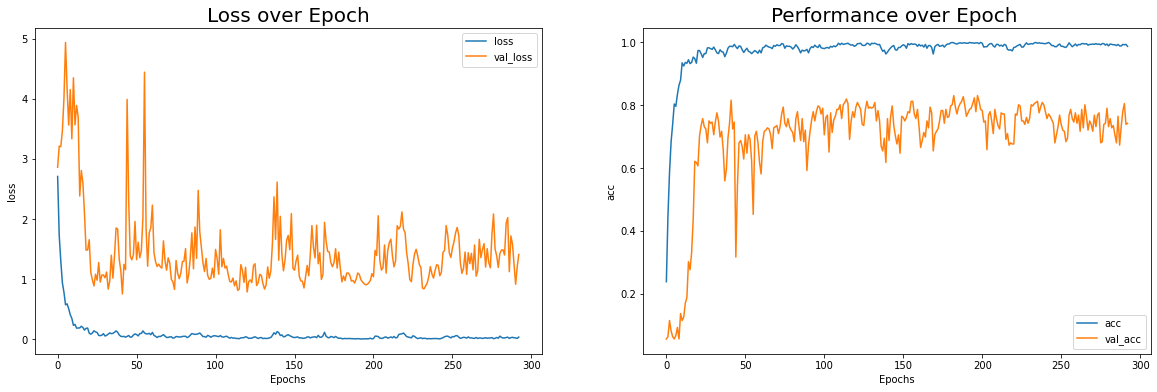


Epoch 00293: val_acc did not improve from 0.83088


In [86]:
history = cnn_model.fit(X_train,y_train,
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_data=(X_val,y_val),
                        callbacks = [liveplot,early_stop,checkpoint],
                        verbose = 0
                        )

In [87]:
cnn_loss, cnn_accu = cnn_model.evaluate(X_test,y_test,verbose=1,)
cnn_loss, cnn_accu

(1.4772177513907938, 0.7389706)

In [88]:
pred_cnn = np.argmax(cnn_model.predict(img_predict))
display(Markdown(f"#### The predicted flower is with label '{pred_cnn}'"))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


#### The predicted flower is with label '2'

In [89]:
score_board = score_board.append({'Model': 'CNN',
                                  'Loss':cnn_loss,
                                  'Accuracy': cnn_accu,
                                  'Predicted Label':pred_cnn,
                                  'Notes':' Label Correctly Predicted'},ignore_index=True)

score_board

,Model,Loss,Accuracy,Predicted Label,Notes
0,CNN,1.477218,0.738971,2,Label Correctly Predicted


### (3.6) Using VGG-16 for Image detection

In [90]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import optimizers
model_type = 'vgg16'


#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(img_rsz_ht,img_rsz_wd,num_channels))

# print(vgg_conv.layers)
# Freeze all the layers except for the last layer: 
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
# Create the model
vgg_model = Sequential()
 
# Add the vgg convolutional base model
vgg_model.add(vgg_conv)

vgg_model.add(Flatten())
vgg_model.add(Dense(1024, activation='relu'))
vgg_model.add(Dropout(0.5))

vgg_model.add(Dense(op_classes, activation='softmax'))
vgg_model.compile(optimizer=optimizers.RMSprop(lr=2e-4), loss='categorical_crossentropy', metrics=['acc','top_k_categorical_accuracy'])
vgg_model.summary() 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 17)                17425     
Total params: 40,423,249
Trainable params: 32,787,985
Non-trainable params: 7,635,264
_________________________________________________________________


In [91]:
checkpoint = ModelCheckpoint(f'{project_path}/{model_type}_'+'{val_acc:.2f}_flower_classifier.h5',
                                                save_best_only=True, 
                                                monitor='val_acc', 
                                                mode='max', 
                                                verbose = 1)

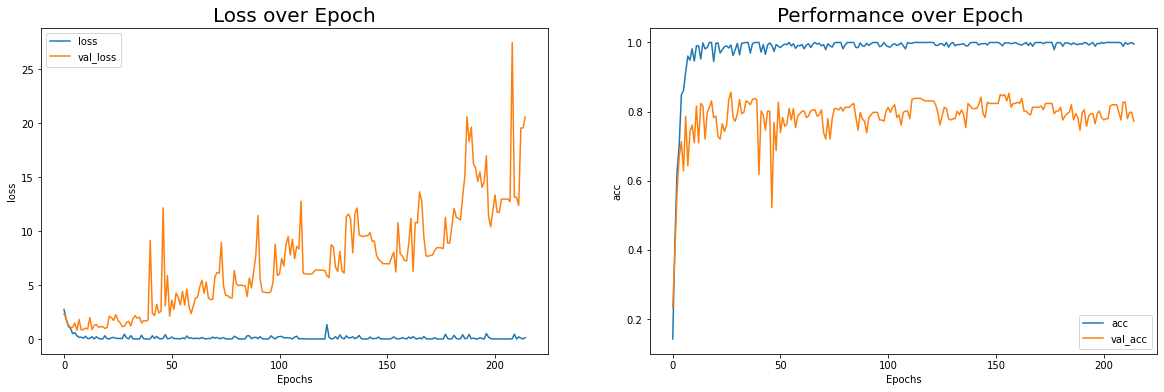


Epoch 00215: val_acc did not improve from 0.85662


In [92]:
history_vgg = vgg_model.fit(X_train,y_train,
              epochs=epochs, 
              batch_size=batch_size,
              validation_data=(X_val,y_val),
              callbacks = [liveplot,early_stop,checkpoint],
              verbose = 0
              )

In [93]:
vgg_loss, vgg_accu, vgg_k_top = vgg_model.evaluate(X_test,y_test)
vgg_loss, vgg_accu, vgg_k_top

(27.30630616580739, 0.7463235, 0.97794116)

In [94]:
pred_vgg = np.argmax(vgg_model.predict(img_predict))
display(Markdown(f"#### The predicted flower is with label '{pred_vgg}'"))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


#### The predicted flower is with label '2'

In [95]:
score_board = score_board.append({'Model': 'VGG16',
                                  'Loss': vgg_loss,
                                  'Accuracy': vgg_accu,
                                  'Predicted Label':pred_vgg,
                                  'Notes':' Label Correctly Predicted'},ignore_index=True)

score_board

,Model,Loss,Accuracy,Predicted Label,Notes
0,CNN,1.477218,0.738971,2,Label Correctly Predicted
1,VGG16,27.306306,0.746324,2,Label Correctly Predicted


### (3.7) Using ANN for Image detection

In [96]:
model_type = 'ann'
ann_model = createANNModel((img_rsz_ht,img_rsz_wd,num_channels),op_classes)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 150528)            0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 150528)            602112    
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              154141696 
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_17 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)              

In [97]:
checkpoint = ModelCheckpoint(f'{project_path}/{model_type}_'+'{val_acc:.2f}_flower_classifier.h5',
                                                save_best_only=True, 
                                                monitor='val_acc', 
                                                mode='max', 
                                                verbose = 1)

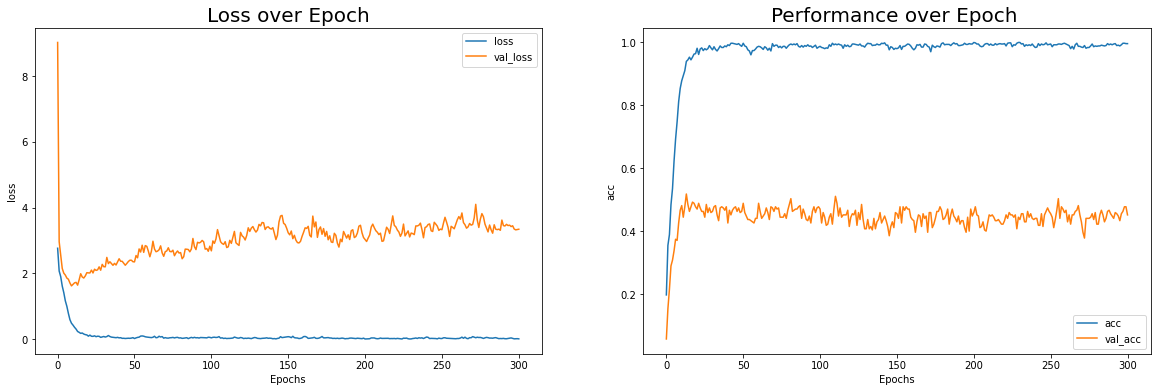


Epoch 00301: val_acc did not improve from 0.51838


In [98]:
history_ann = ann_model.fit(X_train,y_train,
              epochs=epochs, 
              batch_size=batch_size,
              validation_data=(X_val,y_val),
              callbacks = [liveplot,early_stop,checkpoint],
              verbose = 0
              )


In [99]:
ann_loss, ann_accu = ann_model.evaluate(X_test,y_test,verbose=1,)

In [100]:
pred_ann = np.argmax(ann_model.predict(img_predict))
display(Markdown(f"#### The predicted flower is with label '{pred_ann}'"))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


#### The predicted flower is with label '5'

In [101]:
score_board = score_board.append({'Model': 'ANN',
                                  'Loss':ann_loss,
                                  'Accuracy': ann_accu,
                                  'Predicted Label':pred_ann,
                                  'Notes':' Label Incorrectly Predicted'},ignore_index=True)

score_board

,Model,Loss,Accuracy,Predicted Label,Notes
0,CNN,1.477218,0.738971,2,Label Correctly Predicted
1,VGG16,27.306306,0.746324,2,Label Correctly Predicted
2,ANN,3.646097,0.488971,5,Label Incorrectly Predicted


### (3.8) Using SVM for Image detection

In [102]:
def seperate_RGB(X):
  Xr,Xg,Xb = [], [], []
  for samples in X:
    b,g,r = cv2.split(samples)
    Xr.append(r.flatten())
    Xg.append(g.flatten())
    Xb.append(b.flatten())
  Xr = np.array(Xr)
  Xg = np.array(Xg)
  Xb = np.array(Xb)
  return(Xr,Xg,Xb)

In [103]:
Xr_train,Xg_train,Xb_train = seperate_RGB(X_train)
Xr_val,Xg_val,Xb_val = seperate_RGB(X_val)
Xr_test,Xg_test,Xb_test = seperate_RGB(X_test)

Xr_train.shape,Xg_train.shape,Xb_train.shape, Xr_val.shape,Xg_val.shape,Xb_val.shape, Xr_test.shape,Xg_test.shape,Xb_test.shape

((816, 50176),
 (816, 50176),
 (816, 50176),
 (272, 50176),
 (272, 50176),
 (272, 50176),
 (272, 50176),
 (272, 50176),
 (272, 50176))

In [104]:
%%time
n_components = 500
pca_r = PCA(n_components=n_components, whiten=True).fit(Xr_train)
pca_g = PCA(n_components=n_components, whiten=True).fit(Xg_train)
pca_b = PCA(n_components=n_components, whiten=True).fit(Xb_train)

CPU times: user 54.6 s, sys: 27.2 s, total: 1min 21s
Wall time: 22.4 s


In [105]:
%%time
Xr_train_pca = pca_r.transform(Xr_train)
Xg_train_pca = pca_g.transform(Xg_train)
Xb_train_pca = pca_b.transform(Xb_train)

Xr_val_pca = pca_r.transform(Xr_val)
Xg_val_pca = pca_g.transform(Xg_val)
Xb_val_pca = pca_b.transform(Xb_val)

Xr_test_pca = pca_r.transform(Xr_test)
Xg_test_pca = pca_g.transform(Xg_test)
Xb_test_pca = pca_b.transform(Xb_test)



CPU times: user 5.65 s, sys: 1.89 s, total: 7.55 s
Wall time: 2 s


In [106]:
pca_r.explained_variance_ratio_.sum(), pca_g.explained_variance_ratio_.sum(), pca_b.explained_variance_ratio_.sum()

(0.9723562, 0.9634094, 0.9656583)

In [107]:
X_train_pca = np.concatenate([Xr_train_pca,Xg_train_pca,Xb_train_pca],axis=1)
X_val_pca = np.concatenate([Xr_val_pca,Xg_val_pca,Xb_val_pca],axis=1)
X_test_pca = np.concatenate([Xr_test_pca,Xg_test_pca,Xb_test_pca],axis=1)

X_train_pca.shape, y_train.shape, X_val_pca.shape, y_val.shape, X_test_pca.shape, y_test.shape

((816, 1500), (816, 17), (272, 1500), (272, 17), (272, 1500), (272, 17))

#### Convert One-Hot-Encoding to categorical or origicanl class numebrs

In [108]:
y_train_ml = np.array([np.argmax(i) for i in y_train])
y_test_ml = np.array([np.argmax(i) for i in y_test])
y_val_ml = np.array([np.argmax(i) for i in y_val])


In [109]:
%%time
# kwargs = {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
# clf = svm.SVC(**kwargs)
# clf.fit(X_train_pca,y_train_ml)


param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001,0.00001,0.000001], 'kernel': ['rbf']},
 ]
svc = svm.SVC()
clf = GridSearchCV(svc, param_grid,verbose=10,n_jobs=-1)
clf.fit(X_train_pca, y_train_ml)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   53.5s finished


CPU times: user 3.42 s, sys: 479 ms, total: 3.9 s
Wall time: 56.3 s


In [110]:
svm_score = clf.score(X_val_pca,y_val_ml)
svm_score

0.20220588235294118

In [111]:
y_pred = clf.predict(X_test_pca)

svm_accu = metrics.accuracy_score(y_test_ml,y_pred)
svm_accu

0.20955882352941177

In [112]:
pred_img = np.squeeze(img_predict,axis=0)
Xr_pred, Xg_pred, Xb_pred = cv2.split(pred_img)

Xr_pred_pca = pca_r.transform(np.expand_dims(Xr_pred.flatten(),axis=0))
Xg_pred_pca = pca_g.transform(np.expand_dims(Xg_pred.flatten(),axis=0))
Xb_pred_pca = pca_b.transform(np.expand_dims(Xb_pred.flatten(),axis=0))

X_pred_pca = np.concatenate([Xr_pred_pca,Xg_pred_pca,Xb_pred_pca],axis=1)

In [113]:
pred_svm = clf.predict(X_pred_pca)[0]

display(Markdown(f"#### The predicted flower is with label '{pred_svm}'"))

#### The predicted flower is with label '11'

In [114]:
score_board = score_board.append({'Model': 'SVM',
                                  'Loss': 'NA',
                                  'Accuracy': svm_accu,
                                  'Predicted Label':pred_svm,
                                  'Notes':' Label Incorrectly Predicted'},ignore_index=True)

score_board

,Model,Loss,Accuracy,Predicted Label,Notes
0,CNN,1.47722,0.738971,2,Label Correctly Predicted
1,VGG16,27.3063,0.746324,2,Label Correctly Predicted
2,ANN,3.6461,0.488971,5,Label Incorrectly Predicted
3,SVM,NA,0.209559,11,Label Incorrectly Predicted


### (3.9) Using XGBoost for Image detection



In [115]:
xgbmodel = XGBClassifier(objective='multi:softprob', num_class= op_classes)
xgbmodel.fit(X_train_pca, y_train_ml)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=17, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [116]:
xgbmodel.score(X_val_pca,y_val_ml)


0.33088235294117646

In [117]:
y_pred = xgbmodel.predict(X_test_pca)
xgb_accu = metrics.accuracy_score(y_test_ml,y_pred)
xgb_accu

0.3639705882352941

In [118]:
pred_xgb = xgbmodel.predict(X_pred_pca)[0]

display(Markdown(f"#### The predicted flower is with label '{pred_xgb}'"))

#### The predicted flower is with label '11'

In [119]:
score_board = score_board.append({'Model': 'XGBoost',
                                  'Loss': 'NA',
                                  'Accuracy': xgb_accu,
                                  'Predicted Label':pred_xgb,
                                  'Notes':' Label Incorrectly Predicted'},ignore_index=True)

score_board

,Model,Loss,Accuracy,Predicted Label,Notes
0,CNN,1.47722,0.738971,2,Label Correctly Predicted
1,VGG16,27.3063,0.746324,2,Label Correctly Predicted
2,ANN,3.6461,0.488971,5,Label Incorrectly Predicted
3,SVM,NA,0.209559,11,Label Incorrectly Predicted
4,XGBoost,NA,0.363971,11,Label Incorrectly Predicted


#### List of all Model Checkpoint files.

In [127]:
[ files for files in os.listdir(project_path) if files.endswith("h5")]

['cnn_0.87_flower_classifier.h5',
 'vgg16_0.86_flower_classifier.h5',
 'ann_0.54_flower_classifier.h5',
 'cnn_0.06_flower_classifier.h5',
 'cnn_0.11_flower_classifier.h5',
 'cnn_0.14_flower_classifier.h5',
 'cnn_0.17_flower_classifier.h5',
 'cnn_0.19_flower_classifier.h5',
 'cnn_0.30_flower_classifier.h5',
 'cnn_0.33_flower_classifier.h5',
 'cnn_0.44_flower_classifier.h5',
 'cnn_0.62_flower_classifier.h5',
 'cnn_0.70_flower_classifier.h5',
 'cnn_0.74_flower_classifier.h5',
 'cnn_0.76_flower_classifier.h5',
 'cnn_0.78_flower_classifier.h5',
 'cnn_0.82_flower_classifier.h5',
 'cnn_0.83_flower_classifier.h5',
 'vgg16_0.23_flower_classifier.h5',
 'vgg16_0.39_flower_classifier.h5',
 'vgg16_0.57_flower_classifier.h5',
 'vgg16_0.67_flower_classifier.h5',
 'vgg16_0.71_flower_classifier.h5',
 'vgg16_0.79_flower_classifier.h5',
 'vgg16_0.82_flower_classifier.h5',
 'vgg16_0.83_flower_classifier.h5',
 'ann_0.06_flower_classifier.h5',
 'ann_0.15_flower_classifier.h5',
 'ann_0.22_flower_classifier.h

#### Observations:
1. We will use the checkpointed model from CNN and VGG16 to predict the flower species by label

#### Testing the checkpointed model from CNN and VGG16

In [178]:
model_file_list = ['cnn_0.82_flower_classifier.h5','vgg16_0.83_flower_classifier.h5' ]
model_list = ['CNN','VGG16']

In [182]:
for mdl_file, model_typ in zip(model_file_list,model_list):
  test_model = tf.keras.models.load_model(project_path + '/' + mdl_file)
  if model_typ == 'VGG16':
    test_model_loss, test_model_acc, _ = test_model.evaluate(X_test,y_test,verbose=1)
  else:
    test_model_loss, test_model_acc = test_model.evaluate(X_test,y_test,verbose=1)

  test_model_prediction = np.argmax(test_model.predict(img_predict))
  display(Markdown(f"#### Model : {model_typ}, File Name : {mdl_file},  Loss : {test_model_loss:.4f} Accuracy : {test_model_acc:.2f} Prediction: Flower Species {test_model_prediction} "))

#### Model : CNN, File Name : cnn_0.82_flower_classifier.h5,  Loss : 0.9843 Accuracy : 0.80 Prediction: Flower Species 2 

#### Model : VGG16, File Name : vgg16_0.83_flower_classifier.h5,  Loss : 2.1586 Accuracy : 0.79 Prediction: Flower Species 2 

#### Observations:
1. Test successful and prediction is also correct.
2. We will now use this within an application to predict the flower species.

# (4) Conclusion

1. We have seen that using VGG16 as `transfer learning` technique yields better result when compared to a pure `CNN` model.
2. However, both CNN and VGG16 are able to identify the image correctly.
3. ANN, and other ML techniques such as SVM or XGBoost do not provide adequate accuracies to be used for the purpose of image recognition.

## (4.1) Potential Next Steps:
1. As a potential next step, we would like to use CNN as an intermediate layer and try using ANN and other ML classifiers such as SVM or tree bases classifiers.

In [183]:
# import time
# time.sleep(21600)
# print("Woke up from sleep")